Upload the basic notebook

In [1]:
%%capture
%run foundation_notebook.ipynb

In [2]:
print("Notebook run successfully!")

Notebook run successfully!


# 5. Multi-classifier - architecture

We build a simple multi-classifier, which distinguish between ULDM of any kind and noise.

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten, Input, BatchNormalization, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
np.random.seed(42)

Upload the suggested multi-classifier architecture (function)

In [7]:
import importlib
import multi_classifier_function  # Import the module first

importlib.reload(multi_classifier_function)  # Reload the module
from multi_classifier_function import MultiClassifier

# 6. Training data generation

In [9]:
# size of datasets
size = 5000

# mass interval - we focused on a subset of the whole range
mmin = 1e-21 * u.eV
mmax = 1e-21 * u.eV

### C. White and red noise, NP incl.

1. run - data

In [15]:
data_noise_r1_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

In [16]:
data_s0l_30_r1_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s0l", noise_model = "combined", nuis_control = 1)

In [17]:
data_s0q_30_r1_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s0q", noise_model = "combined", nuis_control = 1)

In [18]:
data_s1_30_r1_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s1",  noise_model = "combined", nuis_control = 1)

In [19]:
data_s2_30_r1_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s2",  noise_model = "combined", nuis_control = 1)

In [20]:
combined_all_r1_C = np.concatenate((data_noise_r1_C, data_s0l_30_r1_C, data_s0q_30_r1_C, data_s1_30_r1_C, data_s2_30_r1_C))

scaler_all_C = MinMaxScaler()

combined_all_r1_C_normalized = scaler_all_C.fit_transform(combined_all_r1_C)

In [21]:
import pickle

# Save the scalar
with open('store/files/multiclassifier/scaler_all_C.pkl', 'wb') as f:
    pickle.dump(scaler_all_C, f)

In [79]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

class_labels = np.array(["noise","spin0l", "spin0q", "spin1", "spin2"])

# Step 1: Label encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(class_labels)
print("Integer Encoded Labels:", integer_encoded)
# Output: [0 1 2 3 4 3 0] (example)

# Step 2: One-hot encoding
one_hot_encoded = to_categorical(integer_encoded, num_classes=5)
print("One-Hot Encoded Labels:\n", one_hot_encoded)

Integer Encoded Labels: [0 1 2 3 4]
One-Hot Encoded Labels:
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


Data 1 - normalized

In [24]:
# normalization of raw data
norm_data_noise_r1_C  = scaler_all_C.transform(data_noise_r1_C)
norm_data_s0l_30_r1_C = scaler_all_C.transform(data_s0l_30_r1_C)
norm_data_s0q_30_r1_C = scaler_all_C.transform(data_s0q_30_r1_C)
norm_data_s1_30_r1_C  = scaler_all_C.transform(data_s1_30_r1_C)
norm_data_s2_30_r1_C  = scaler_all_C.transform(data_s2_30_r1_C)

# labeling
y_0_noise_r1_C  = np.array([one_hot_encoded[0] for i in range(size)])
y_1_spin0l_r1_C = np.array([one_hot_encoded[1] for i in range(size)])
y_1_spin0q_r1_C = np.array([one_hot_encoded[2] for i in range(size)])
y_1_spin1_r1_C  = np.array([one_hot_encoded[3] for i in range(size)])
y_1_spin2_r1_C  = np.array([one_hot_encoded[4] for i in range(size)])

# build X and y
X_all_r1_C = np.concatenate(( norm_data_noise_r1_C, norm_data_s0l_30_r1_C, norm_data_s0q_30_r1_C, norm_data_s1_30_r1_C, norm_data_s2_30_r1_C ))
y_all_r1_C = np.concatenate(( y_0_noise_r1_C,       y_1_spin0l_r1_C,       y_1_spin0q_r1_C,       y_1_spin1_r1_C,       y_1_spin2_r1_C ))

# shuffle
indices_r1_C       = np.random.permutation(X_all_r1_C.shape[0])
X_all_r1_C_shuffle = X_all_r1_C[indices_r1_C]
y_all_r1_C_shuffle = y_all_r1_C[indices_r1_C]

# split
split_r1_C       = int( 0.8 * len(X_all_r1_C_shuffle) )
X_all_r1_C_train = X_all_r1_C_shuffle[:split_r1_C]
y_all_r1_C_train = y_all_r1_C_shuffle[:split_r1_C]
X_all_r1_C_val   = X_all_r1_C_shuffle[split_r1_C:]
y_all_r1_C_val   = y_all_r1_C_shuffle[split_r1_C:]

In [25]:
import pickle

# Define your dictionaries as given
Xy_all_r1_C = { 
    'X_all_r1_C_train': X_all_r1_C_train, 
    'y_all_r1_C_train': y_all_r1_C_train, 
    'X_all_r1_C_val': X_all_r1_C_val, 
    'y_all_r1_C_val': y_all_r1_C_val 
}
# Save the dictionary to a pickle file
with open('store/files/multiclassifier/Xy_all_r1_C.pkl', 'wb') as f:
    pickle.dump({'Xy_all_r1_C': Xy_all_r1_C}, f)

print("Pickle file saved successfully.")

Pickle file saved successfully.


In [26]:
del data_noise_r1_C, data_s0l_30_r1_C, data_s0q_30_r1_C, data_s1_30_r1_C, data_s2_30_r1_C
del combined_all_r1_C, combined_all_r1_C_normalized
del norm_data_noise_r1_C, norm_data_s0l_30_r1_C, norm_data_s0q_30_r1_C, norm_data_s1_30_r1_C, norm_data_s2_30_r1_C
del y_0_noise_r1_C,       y_1_spin0l_r1_C,       y_1_spin0q_r1_C,       y_1_spin1_r1_C,       y_1_spin2_r1_C
del X_all_r1_C, y_all_r1_C, X_all_r1_C_shuffle, y_all_r1_C_shuffle
del X_all_r1_C_train, y_all_r1_C_train, X_all_r1_C_val, y_all_r1_C_val

2. run - data

In [28]:
data_noise_r2_C  = Nruns_noisydata_SNR_fixed(N = 2 * size, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

data_s0l_30_r2_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_30_r2_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_30_r2_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_30_r2_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s2",  noise_model = "combined", nuis_control = 1)

data_s0l_27_r2_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_27_r2_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_27_r2_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_27_r2_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s2",  noise_model = "combined", nuis_control = 1)

In [29]:
# normalization of raw data
norm_data_noise_r2_C  = scaler_all_C.transform(data_noise_r2_C)

norm_data_s0l_30_r2_C = scaler_all_C.transform(data_s0l_30_r2_C)
norm_data_s0q_30_r2_C = scaler_all_C.transform(data_s0q_30_r2_C)
norm_data_s1_30_r2_C  = scaler_all_C.transform(data_s1_30_r2_C)
norm_data_s2_30_r2_C  = scaler_all_C.transform(data_s2_30_r2_C)

norm_data_s0l_27_r2_C = scaler_all_C.transform(data_s0l_27_r2_C)
norm_data_s0q_27_r2_C = scaler_all_C.transform(data_s0q_27_r2_C)
norm_data_s1_27_r2_C  = scaler_all_C.transform(data_s1_27_r2_C)
norm_data_s2_27_r2_C  = scaler_all_C.transform(data_s2_27_r2_C)

# labeling
y_0_noise_r2_C  = np.array([one_hot_encoded[0] for i in range(2 * size)])
y_1_spin0l_r2_C = np.array([one_hot_encoded[1] for i in range(2 * size)])
y_1_spin0q_r2_C = np.array([one_hot_encoded[2] for i in range(2 * size)])
y_1_spin1_r2_C  = np.array([one_hot_encoded[3] for i in range(2 * size)])
y_1_spin2_r2_C  = np.array([one_hot_encoded[4] for i in range(2 * size)])

# build X and y
X_all_r2_C = np.concatenate(( norm_data_noise_r2_C, 
                              norm_data_s0l_30_r2_C, norm_data_s0l_27_r2_C,
                              norm_data_s0q_30_r2_C, norm_data_s0q_27_r2_C,
                              norm_data_s1_30_r2_C,  norm_data_s1_27_r2_C,
                              norm_data_s2_30_r2_C,  norm_data_s2_27_r2_C ))

y_all_r2_C = np.concatenate(( y_0_noise_r2_C, y_1_spin0l_r2_C, y_1_spin0q_r2_C, y_1_spin1_r2_C, y_1_spin2_r2_C ))

# shuffle
indices_r2_C       = np.random.permutation(X_all_r2_C.shape[0])
X_all_r2_C_shuffle = X_all_r2_C[indices_r2_C]
y_all_r2_C_shuffle = y_all_r2_C[indices_r2_C]

# split
split_r2_C       = int( 0.8 * len(X_all_r2_C_shuffle) )
X_all_r2_C_train = X_all_r2_C_shuffle[:split_r2_C]
y_all_r2_C_train = y_all_r2_C_shuffle[:split_r2_C]
X_all_r2_C_val   = X_all_r2_C_shuffle[split_r2_C:]
y_all_r2_C_val   = y_all_r2_C_shuffle[split_r2_C:]

In [30]:
import pickle

# Define your dictionaries as given
Xy_all_r2_C = { 
    'X_all_r2_C_train': X_all_r2_C_train, 
    'y_all_r2_C_train': y_all_r2_C_train, 
    'X_all_r2_C_val': X_all_r2_C_val, 
    'y_all_r2_C_val': y_all_r2_C_val 
}
# Save the dictionary to a pickle file
with open('store/files/multiclassifier/Xy_all_r2_C.pkl', 'wb') as f:
    pickle.dump({'Xy_all_r2_C': Xy_all_r2_C}, f)

print("Pickle file saved successfully.")

Pickle file saved successfully.


In [31]:
#del data_noise_r2_C, data_s0l_30_r2_C, data_s0q_30_r2_C, data_s1_30_r2_C, data_s2_30_r2_C
del norm_data_noise_r2_C, norm_data_s0l_30_r2_C, norm_data_s0q_30_r2_C, norm_data_s1_30_r2_C, norm_data_s2_30_r2_C
del y_0_noise_r2_C,       y_1_spin0l_r2_C,       y_1_spin0q_r2_C,       y_1_spin1_r2_C,       y_1_spin2_r2_C
del X_all_r2_C, y_all_r2_C, X_all_r2_C_shuffle, y_all_r2_C_shuffle
del X_all_r2_C_train, y_all_r2_C_train, X_all_r2_C_val, y_all_r2_C_val

3. run - data

In [33]:
data_noise_r3_C  = Nruns_noisydata_SNR_fixed(N = 3 * size, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

data_s0l_30_r3_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_30_r3_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_30_r3_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_30_r3_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s2",  noise_model = "combined", nuis_control = 1)

data_s0l_27_r3_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_27_r3_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_27_r3_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_27_r3_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s2",  noise_model = "combined", nuis_control = 1)

data_s0l_24_r3_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 24, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_24_r3_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 24, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_24_r3_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 24, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_24_r3_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 24, spin = "s2",  noise_model = "combined", nuis_control = 1)

In [34]:
# normalization of raw data
norm_data_noise_r3_C  = scaler_all_C.transform(data_noise_r3_C)

norm_data_s0l_30_r3_C = scaler_all_C.transform(data_s0l_30_r3_C)
norm_data_s0q_30_r3_C = scaler_all_C.transform(data_s0q_30_r3_C)
norm_data_s1_30_r3_C  = scaler_all_C.transform(data_s1_30_r3_C)
norm_data_s2_30_r3_C  = scaler_all_C.transform(data_s2_30_r3_C)

norm_data_s0l_27_r3_C = scaler_all_C.transform(data_s0l_27_r3_C)
norm_data_s0q_27_r3_C = scaler_all_C.transform(data_s0q_27_r3_C)
norm_data_s1_27_r3_C  = scaler_all_C.transform(data_s1_27_r3_C)
norm_data_s2_27_r3_C  = scaler_all_C.transform(data_s2_27_r3_C)

norm_data_s0l_24_r3_C = scaler_all_C.transform(data_s0l_24_r3_C)
norm_data_s0q_24_r3_C = scaler_all_C.transform(data_s0q_24_r3_C)
norm_data_s1_24_r3_C  = scaler_all_C.transform(data_s1_24_r3_C)
norm_data_s2_24_r3_C  = scaler_all_C.transform(data_s2_24_r3_C)

# labeling
y_0_noise_r3_C  = np.array([one_hot_encoded[0] for i in range(3 * size)])
y_1_spin0l_r3_C = np.array([one_hot_encoded[1] for i in range(3 * size)])
y_1_spin0q_r3_C = np.array([one_hot_encoded[2] for i in range(3 * size)])
y_1_spin1_r3_C  = np.array([one_hot_encoded[3] for i in range(3 * size)])
y_1_spin2_r3_C  = np.array([one_hot_encoded[4] for i in range(3 * size)])

# build X and y
X_all_r3_C = np.concatenate(( norm_data_noise_r3_C, 
                              norm_data_s0l_30_r3_C, norm_data_s0l_27_r3_C, norm_data_s0l_24_r3_C,
                              norm_data_s0q_30_r3_C, norm_data_s0q_27_r3_C, norm_data_s0q_24_r3_C,
                              norm_data_s1_30_r3_C,  norm_data_s1_27_r3_C,  norm_data_s1_24_r3_C,
                              norm_data_s2_30_r3_C,  norm_data_s2_27_r3_C , norm_data_s2_24_r3_C))

y_all_r3_C = np.concatenate(( y_0_noise_r3_C, y_1_spin0l_r3_C, y_1_spin0q_r3_C, y_1_spin1_r3_C, y_1_spin2_r3_C ))

# shuffle
indices_r3_C       = np.random.permutation(X_all_r3_C.shape[0])
X_all_r3_C_shuffle = X_all_r3_C[indices_r3_C]
y_all_r3_C_shuffle = y_all_r3_C[indices_r3_C]

# split
split_r3_C       = int( 0.8 * len(X_all_r3_C_shuffle) )
X_all_r3_C_train = X_all_r3_C_shuffle[:split_r3_C]
y_all_r3_C_train = y_all_r3_C_shuffle[:split_r3_C]
X_all_r3_C_val   = X_all_r3_C_shuffle[split_r3_C:]
y_all_r3_C_val   = y_all_r3_C_shuffle[split_r3_C:]

In [35]:
import pickle

# Define your dictionaries as given
Xy_all_r3_C = { 
    'X_all_r3_C_train': X_all_r3_C_train, 
    'y_all_r3_C_train': y_all_r3_C_train, 
    'X_all_r3_C_val': X_all_r3_C_val, 
    'y_all_r3_C_val': y_all_r3_C_val 
}
# Save the dictionary to a pickle file
with open('store/files/multiclassifier/Xy_all_r3_C.pkl', 'wb') as f:
    pickle.dump({'Xy_all_r3_C': Xy_all_r3_C}, f)

print("Pickle file saved successfully.")

Pickle file saved successfully.


In [36]:
del data_noise_r3_C, data_s0l_30_r3_C, data_s0q_30_r3_C, data_s1_30_r3_C, data_s2_30_r3_C
del norm_data_noise_r3_C, norm_data_s0l_30_r3_C, norm_data_s0q_30_r3_C, norm_data_s1_30_r3_C, norm_data_s2_30_r3_C
del y_0_noise_r3_C,       y_1_spin0l_r3_C,       y_1_spin0q_r3_C,       y_1_spin1_r3_C,       y_1_spin2_r3_C
del X_all_r3_C, y_all_r3_C, X_all_r3_C_shuffle, y_all_r3_C_shuffle
del X_all_r3_C_train, y_all_r3_C_train, X_all_r3_C_val, y_all_r3_C_val

4. run - data

In [38]:
data_noise_r4_C  = Nruns_noisydata_SNR_fixed(N = 4 * size, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

data_s0l_30_r4_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_30_r4_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_30_r4_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_30_r4_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s2",  noise_model = "combined", nuis_control = 1)

data_s0l_27_r4_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_27_r4_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_27_r4_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_27_r4_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s2",  noise_model = "combined", nuis_control = 1)

data_s0l_24_r4_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 24, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_24_r4_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 24, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_24_r4_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 24, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_24_r4_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 24, spin = "s2",  noise_model = "combined", nuis_control = 1)

data_s0l_21_r4_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 21, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_21_r4_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 21, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_21_r4_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 21, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_21_r4_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 21, spin = "s2",  noise_model = "combined", nuis_control = 1)

In [39]:
# normalization of raw data
norm_data_noise_r4_C  = scaler_all_C.transform(data_noise_r4_C)

norm_data_s0l_30_r4_C = scaler_all_C.transform(data_s0l_30_r4_C)
norm_data_s0q_30_r4_C = scaler_all_C.transform(data_s0q_30_r4_C)
norm_data_s1_30_r4_C  = scaler_all_C.transform(data_s1_30_r4_C)
norm_data_s2_30_r4_C  = scaler_all_C.transform(data_s2_30_r4_C)

norm_data_s0l_27_r4_C = scaler_all_C.transform(data_s0l_27_r4_C)
norm_data_s0q_27_r4_C = scaler_all_C.transform(data_s0q_27_r4_C)
norm_data_s1_27_r4_C  = scaler_all_C.transform(data_s1_27_r4_C)
norm_data_s2_27_r4_C  = scaler_all_C.transform(data_s2_27_r4_C)

norm_data_s0l_24_r4_C = scaler_all_C.transform(data_s0l_24_r4_C)
norm_data_s0q_24_r4_C = scaler_all_C.transform(data_s0q_24_r4_C)
norm_data_s1_24_r4_C  = scaler_all_C.transform(data_s1_24_r4_C)
norm_data_s2_24_r4_C  = scaler_all_C.transform(data_s2_24_r4_C)

norm_data_s0l_21_r4_C = scaler_all_C.transform(data_s0l_21_r4_C)
norm_data_s0q_21_r4_C = scaler_all_C.transform(data_s0q_21_r4_C)
norm_data_s1_21_r4_C  = scaler_all_C.transform(data_s1_21_r4_C)
norm_data_s2_21_r4_C  = scaler_all_C.transform(data_s2_21_r4_C)

# labeling
y_0_noise_r4_C  = np.array([one_hot_encoded[0] for i in range(4 * size)])
y_1_spin0l_r4_C = np.array([one_hot_encoded[1] for i in range(4 * size)])
y_1_spin0q_r4_C = np.array([one_hot_encoded[2] for i in range(4 * size)])
y_1_spin1_r4_C  = np.array([one_hot_encoded[3] for i in range(4 * size)])
y_1_spin2_r4_C  = np.array([one_hot_encoded[4] for i in range(4 * size)])

# build X and y
X_all_r4_C = np.concatenate(( norm_data_noise_r4_C, 
                              norm_data_s0l_30_r4_C, norm_data_s0l_27_r4_C, norm_data_s0l_24_r4_C, data_s0l_21_r4_C,
                              norm_data_s0q_30_r4_C, norm_data_s0q_27_r4_C, norm_data_s0q_24_r4_C, data_s0q_21_r4_C,
                              norm_data_s1_30_r4_C,  norm_data_s1_27_r4_C,  norm_data_s1_24_r4_C,  data_s1_21_r4_C,
                              norm_data_s2_30_r4_C,  norm_data_s2_27_r4_C , norm_data_s2_24_r4_C,  data_s2_21_r4_C))

y_all_r4_C = np.concatenate(( y_0_noise_r4_C, y_1_spin0l_r4_C, y_1_spin0q_r4_C, y_1_spin1_r4_C, y_1_spin2_r4_C ))

# shuffle
indices_r4_C       = np.random.permutation(X_all_r4_C.shape[0])
X_all_r4_C_shuffle = X_all_r4_C[indices_r4_C]
y_all_r4_C_shuffle = y_all_r4_C[indices_r4_C]

# split
split_r4_C       = int( 0.8 * len(X_all_r4_C_shuffle) )
X_all_r4_C_train = X_all_r4_C_shuffle[:split_r4_C]
y_all_r4_C_train = y_all_r4_C_shuffle[:split_r4_C]
X_all_r4_C_val   = X_all_r4_C_shuffle[split_r4_C:]
y_all_r4_C_val   = y_all_r4_C_shuffle[split_r4_C:]

In [40]:
import pickle

# Define your dictionaries as given
Xy_all_r4_C = { 
    'X_all_r4_C_train': X_all_r4_C_train, 
    'y_all_r4_C_train': y_all_r4_C_train, 
    'X_all_r4_C_val': X_all_r4_C_val, 
    'y_all_r4_C_val': y_all_r4_C_val 
}
# Save the dictionary to a pickle file
with open('store/files/multiclassifier/Xy_all_r4_C.pkl', 'wb') as f:
    pickle.dump({'Xy_all_r4_C': Xy_all_r4_C}, f)

print("Pickle file saved successfully.")

Pickle file saved successfully.


In [41]:
del data_noise_r4_C, data_s0l_30_r4_C, data_s0q_30_r4_C, data_s1_30_r4_C, data_s2_30_r4_C
del norm_data_noise_r4_C, norm_data_s0l_30_r4_C, norm_data_s0q_30_r4_C, norm_data_s1_30_r4_C, norm_data_s2_30_r4_C
del y_0_noise_r4_C,       y_1_spin0l_r4_C,       y_1_spin0q_r4_C,       y_1_spin1_r4_C,       y_1_spin2_r4_C
del X_all_r4_C, y_all_r4_C, X_all_r4_C_shuffle, y_all_r4_C_shuffle
del X_all_r4_C_train, y_all_r4_C_train, X_all_r4_C_val, y_all_r4_C_val

5. run - data

In [76]:
data_noise_r5_C  = Nruns_noisydata_SNR_fixed(N = 5 * size, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

print("Done - noise")

data_s0l_30_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_30_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_30_r5_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_30_r5_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 30, spin = "s2",  noise_model = "combined", nuis_control = 1)

print("Done - 30")

data_s0l_27_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_27_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_27_r5_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_27_r5_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 27, spin = "s2",  noise_model = "combined", nuis_control = 1)

print("Done - 27")

data_s0l_24_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 24, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_24_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 24, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_24_r5_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 24, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_24_r5_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 24, spin = "s2",  noise_model = "combined", nuis_control = 1)

print("Done - 24")

data_s0l_21_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 21, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_21_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 21, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_21_r5_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 21, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_21_r5_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 21, spin = "s2",  noise_model = "combined", nuis_control = 1)

print("Done - 21")

data_s0l_18_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 18, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_18_r5_C = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 18, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_18_r5_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 18, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_18_r5_C  = Nruns_noisydata_SNR_fixed(N = size, m_list = [mmin, mmax], snr = 18, spin = "s2",  noise_model = "combined", nuis_control = 1)

print("Done - 18")

Done - noise
Done - 30
Done - 27
Done - 24
Done - 21
Done - 18


In [82]:
# normalization of raw data
norm_data_noise_r5_C  = scaler_all_C.transform(data_noise_r5_C)

norm_data_s0l_30_r5_C = scaler_all_C.transform(data_s0l_30_r5_C)
norm_data_s0q_30_r5_C = scaler_all_C.transform(data_s0q_30_r5_C)
norm_data_s1_30_r5_C  = scaler_all_C.transform(data_s1_30_r5_C)
norm_data_s2_30_r5_C  = scaler_all_C.transform(data_s2_30_r5_C)

norm_data_s0l_27_r5_C = scaler_all_C.transform(data_s0l_27_r5_C)
norm_data_s0q_27_r5_C = scaler_all_C.transform(data_s0q_27_r5_C)
norm_data_s1_27_r5_C  = scaler_all_C.transform(data_s1_27_r5_C)
norm_data_s2_27_r5_C  = scaler_all_C.transform(data_s2_27_r5_C)

norm_data_s0l_24_r5_C = scaler_all_C.transform(data_s0l_24_r5_C)
norm_data_s0q_24_r5_C = scaler_all_C.transform(data_s0q_24_r5_C)
norm_data_s1_24_r5_C  = scaler_all_C.transform(data_s1_24_r5_C)
norm_data_s2_24_r5_C  = scaler_all_C.transform(data_s2_24_r5_C)

norm_data_s0l_21_r5_C = scaler_all_C.transform(data_s0l_21_r5_C)
norm_data_s0q_21_r5_C = scaler_all_C.transform(data_s0q_21_r5_C)
norm_data_s1_21_r5_C  = scaler_all_C.transform(data_s1_21_r5_C)
norm_data_s2_21_r5_C  = scaler_all_C.transform(data_s2_21_r5_C)

norm_data_s0l_18_r5_C = scaler_all_C.transform(data_s0l_18_r5_C)
norm_data_s0q_18_r5_C = scaler_all_C.transform(data_s0q_18_r5_C)
norm_data_s1_18_r5_C  = scaler_all_C.transform(data_s1_18_r5_C)
norm_data_s2_18_r5_C  = scaler_all_C.transform(data_s2_18_r5_C)

# labeling
y_0_noise_r5_C  = np.array([one_hot_encoded[0] for i in range(5 * size)])
y_1_spin0l_r5_C = np.array([one_hot_encoded[1] for i in range(5 * size)])
y_1_spin0q_r5_C = np.array([one_hot_encoded[2] for i in range(5 * size)])
y_1_spin1_r5_C  = np.array([one_hot_encoded[3] for i in range(5 * size)])
y_1_spin2_r5_C  = np.array([one_hot_encoded[4] for i in range(5 * size)])

# build X and y
X_all_r5_C = np.concatenate(( norm_data_noise_r5_C, 
                              norm_data_s0l_30_r5_C, norm_data_s0l_27_r5_C, norm_data_s0l_24_r5_C, data_s0l_21_r5_C, data_s0l_18_r5_C,
                              norm_data_s0q_30_r5_C, norm_data_s0q_27_r5_C, norm_data_s0q_24_r5_C, data_s0q_21_r5_C, data_s0q_18_r5_C,
                              norm_data_s1_30_r5_C,  norm_data_s1_27_r5_C,  norm_data_s1_24_r5_C,  data_s1_21_r5_C,  data_s1_18_r5_C,
                              norm_data_s2_30_r5_C,  norm_data_s2_27_r5_C , norm_data_s2_24_r5_C,  data_s2_21_r5_C,  data_s2_18_r5_C))

y_all_r5_C = np.concatenate(( y_0_noise_r5_C, y_1_spin0l_r5_C, y_1_spin0q_r5_C, y_1_spin1_r5_C, y_1_spin2_r5_C ))

# shuffle
indices_r5_C       = np.random.permutation(X_all_r5_C.shape[0])
X_all_r5_C_shuffle = X_all_r5_C[indices_r5_C]
y_all_r5_C_shuffle = y_all_r5_C[indices_r5_C]

# split
split_r5_C       = int( 0.8 * len(X_all_r5_C_shuffle) )
X_all_r5_C_train = X_all_r5_C_shuffle[:split_r5_C]
y_all_r5_C_train = y_all_r5_C_shuffle[:split_r5_C]
X_all_r5_C_val   = X_all_r5_C_shuffle[split_r5_C:]
y_all_r5_C_val   = y_all_r5_C_shuffle[split_r5_C:]

In [86]:
import pickle

# Define your dictionaries as given
Xy_all_r5_C = { 
    'X_all_r5_C_train': X_all_r5_C_train, 
    'y_all_r5_C_train': y_all_r5_C_train, 
    'X_all_r5_C_val': X_all_r5_C_val, 
    'y_all_r5_C_val': y_all_r5_C_val 
}
# Save the dictionary to a pickle file
with open('store/files/multiclassifier/Xy_all_r5_C.pkl', 'wb') as f:
    pickle.dump({'Xy_all_r5_C': Xy_all_r5_C}, f)

print("Pickle file saved successfully.")

Pickle file saved successfully.


# 7. Training

In [17]:
import pickle

# Load the scalar
with open('store/files/multiclassifier/scaler_all_C.pkl', 'rb') as f:
    scaler_all_C = pickle.load(f)

#### Model 1.

In [19]:
import pickle

with open('store/files/multiclassifier/Xy_all_r1_C.pkl', 'rb') as f:
    data = pickle.load(f)
data = data['Xy_all_r1_C']
X_all_r1_C_train = data['X_all_r1_C_train']
y_all_r1_C_train = data['y_all_r1_C_train']
X_all_r1_C_val  = data['X_all_r1_C_val']
y_all_r1_C_val  = data['y_all_r1_C_val']

In [21]:
# Early stopping with restore_best_weights=True
early_stop_r1_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r1_C = 0.001
lr_schedule_r1_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r1_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_all_r1_C     = MultiClassifier(n)
optimizer_all_r1_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r1_C)
model_all_r1_C.compile(optimizer=optimizer_all_r1_C, loss='categorical_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r1_C = ModelCheckpoint(
    "store/files/multiclassifier/best_model_r1_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [23]:
history_r1_C = model_all_r1_C.fit(X_all_r1_C_train, y_all_r1_C_train, epochs=15, batch_size=32, validation_data=(X_all_r1_C_val, y_all_r1_C_val), verbose=2, callbacks=[early_stop_r1_C, checkpoint_r1_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.58840, saving model to store/files/multiclassifier/best_model_r1_C.keras
625/625 - 54s - 86ms/step - accuracy: 0.9049 - loss: 0.3108 - val_accuracy: 0.5884 - val_loss: 3.9094
Epoch 2/15

Epoch 2: val_accuracy improved from 0.58840 to 0.98040, saving model to store/files/multiclassifier/best_model_r1_C.keras
625/625 - 46s - 73ms/step - accuracy: 0.9869 - loss: 0.0432 - val_accuracy: 0.9804 - val_loss: 0.0598
Epoch 3/15

Epoch 3: val_accuracy improved from 0.98040 to 0.98980, saving model to store/files/multiclassifier/best_model_r1_C.keras
625/625 - 85s - 136ms/step - accuracy: 0.9924 - loss: 0.0245 - val_accuracy: 0.9898 - val_loss: 0.0348
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.98980
625/625 - 49s - 78ms/step - accuracy: 0.9929 - loss: 0.0250 - val_accuracy: 0.9780 - val_loss: 0.0911
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.98980
625/625 - 81s - 129ms/step - accuracy: 0.9948 - loss: 0.0208 - val

In [24]:
val_loss_r1_C, val_acc_r1_C = model_all_r1_C.evaluate(X_all_r1_C_val, y_all_r1_C_val)
print(f"Validation Accuracy: {val_acc_r1_C:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9970 - loss: 0.0064
Validation Accuracy: 0.9974


#### Model 2.

In [26]:
import pickle

with open('store/files/multiclassifier/Xy_all_r2_C.pkl', 'rb') as f:
    data = pickle.load(f)
data = data['Xy_all_r2_C']
X_all_r2_C_train = data['X_all_r2_C_train']
y_all_r2_C_train = data['y_all_r2_C_train']
X_all_r2_C_val  = data['X_all_r2_C_val']
y_all_r2_C_val  = data['y_all_r2_C_val']

In [27]:
# Early stopping with restore_best_weights=True
early_stop_r2_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r2_C = 0.001
lr_schedule_r2_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r2_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_all_r2_C     = MultiClassifier(n)
optimizer_all_r2_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r2_C)
model_all_r2_C.compile(optimizer=optimizer_all_r2_C, loss='categorical_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r2_C = ModelCheckpoint(
    "store/files/multiclassifier/best_model_r2_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [28]:
# upload weights
model_all_r2_C.set_weights(model_all_r1_C.get_weights())

In [29]:
history_r2_C = model_all_r2_C.fit(X_all_r2_C_train, y_all_r2_C_train, epochs=15, batch_size=32, validation_data=(X_all_r2_C_val, y_all_r2_C_val), verbose=2, callbacks=[early_stop_r2_C, checkpoint_r2_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.99560, saving model to store/files/multiclassifier/best_model_r2_C.keras
1250/1250 - 91s - 73ms/step - accuracy: 0.9911 - loss: 0.0394 - val_accuracy: 0.9956 - val_loss: 0.0168
Epoch 2/15

Epoch 2: val_accuracy improved from 0.99560 to 0.99700, saving model to store/files/multiclassifier/best_model_r2_C.keras
1250/1250 - 90s - 72ms/step - accuracy: 0.9945 - loss: 0.0246 - val_accuracy: 0.9970 - val_loss: 0.0137
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.99700
1250/1250 - 82s - 65ms/step - accuracy: 0.9966 - loss: 0.0135 - val_accuracy: 0.9969 - val_loss: 0.0329
Epoch 4/15

Epoch 4: val_accuracy improved from 0.99700 to 0.99710, saving model to store/files/multiclassifier/best_model_r2_C.keras
1250/1250 - 79s - 63ms/step - accuracy: 0.9964 - loss: 0.0180 - val_accuracy: 0.9971 - val_loss: 0.0180
Epoch 5/15

Epoch 5: val_accuracy improved from 0.99710 to 0.99770, saving model to store/files/multiclassifier/best_model

In [30]:
val_loss_r2_C, val_acc_r2_C = model_all_r2_C.evaluate(X_all_r2_C_val, y_all_r2_C_val)
print(f"Validation Accuracy: {val_acc_r2_C:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9981 - loss: 0.0115
Validation Accuracy: 0.9977


#### Model 3.

In [32]:
import pickle

with open('store/files/multiclassifier/Xy_all_r3_C.pkl', 'rb') as f:
    data = pickle.load(f)
data = data['Xy_all_r3_C']
X_all_r3_C_train = data['X_all_r3_C_train']
y_all_r3_C_train = data['y_all_r3_C_train']
X_all_r3_C_val  = data['X_all_r3_C_val']
y_all_r3_C_val  = data['y_all_r3_C_val']

In [33]:
# Early stopping with restore_best_weights=True
early_stop_r3_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r3_C = 0.001
lr_schedule_r3_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r3_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_all_r3_C     = MultiClassifier(n)
optimizer_all_r3_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r3_C)
model_all_r3_C.compile(optimizer=optimizer_all_r3_C, loss='categorical_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r3_C = ModelCheckpoint(
    "store/files/multiclassifier/best_model_r3_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [34]:
# upload weights
model_all_r3_C.set_weights(model_all_r2_C.get_weights())

In [35]:
history_r3_C = model_all_r3_C.fit(X_all_r3_C_train, y_all_r3_C_train, epochs=15, batch_size=32, validation_data=(X_all_r3_C_val, y_all_r3_C_val), verbose=2, callbacks=[early_stop_r3_C, checkpoint_r3_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.99740, saving model to store/files/multiclassifier/best_model_r3_C.keras
1875/1875 - 129s - 69ms/step - accuracy: 0.9934 - loss: 0.0312 - val_accuracy: 0.9974 - val_loss: 0.0092
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.99740
1875/1875 - 118s - 63ms/step - accuracy: 0.9962 - loss: 0.0163 - val_accuracy: 0.9974 - val_loss: 0.0219
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.99740
1875/1875 - 118s - 63ms/step - accuracy: 0.9975 - loss: 0.0130 - val_accuracy: 0.9920 - val_loss: 0.0391
Epoch 4/15

Epoch 4: val_accuracy improved from 0.99740 to 0.99780, saving model to store/files/multiclassifier/best_model_r3_C.keras
1875/1875 - 115s - 62ms/step - accuracy: 0.9972 - loss: 0.0141 - val_accuracy: 0.9978 - val_loss: 0.0103
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.99780
1875/1875 - 117s - 62ms/step - accuracy: 0.9978 - loss: 0.0109 - val_accuracy: 0.9974 - val_loss: 0.0135
Epoch 6/15

Epoch 6: 

In [36]:
val_loss_r3_C, val_acc_r3_C = model_all_r3_C.evaluate(X_all_r3_C_val, y_all_r3_C_val)
print(f"Validation Accuracy: {val_acc_r3_C:.4f}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9973 - loss: 0.0150
Validation Accuracy: 0.9978


#### Model 4.

In [38]:
import pickle

with open('store/files/multiclassifier/Xy_all_r4_C.pkl', 'rb') as f:
    data = pickle.load(f)
data = data['Xy_all_r4_C']
X_all_r4_C_train = data['X_all_r4_C_train']
y_all_r4_C_train = data['y_all_r4_C_train']
X_all_r4_C_val  = data['X_all_r4_C_val']
y_all_r4_C_val  = data['y_all_r4_C_val']

In [39]:
# Early stopping with restore_best_weights=True
early_stop_r4_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation accuracy
    patience=5,               # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# Learning rate schedule
initial_learning_rate_r4_C = 0.001
lr_schedule_r4_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r4_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# Model
model_all_r4_C     = MultiClassifier(n)
optimizer_all_r4_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r4_C)
model_all_r4_C.compile(optimizer=optimizer_all_r4_C, loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model
checkpoint_r4_C = ModelCheckpoint(
    "store/files/multiclassifier/best_model_r4_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [40]:
# upload weights
model_all_r4_C.set_weights(model_all_r3_C.get_weights())

In [41]:
history_r4_C = model_all_r4_C.fit(X_all_r4_C_train, y_all_r4_C_train, epochs=15, batch_size=32, validation_data=(X_all_r4_C_val, y_all_r4_C_val), verbose=2, callbacks=[early_stop_r4_C, checkpoint_r4_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.84215, saving model to store/files/multiclassifier/best_model_r4_C.keras
2500/2500 - 159s - 63ms/step - accuracy: 0.8331 - loss: 0.3501 - val_accuracy: 0.8421 - val_loss: 0.3007
Epoch 2/15

Epoch 2: val_accuracy improved from 0.84215 to 0.84530, saving model to store/files/multiclassifier/best_model_r4_C.keras
2500/2500 - 154s - 62ms/step - accuracy: 0.8480 - loss: 0.2987 - val_accuracy: 0.8453 - val_loss: 0.2910
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.84530
2500/2500 - 157s - 63ms/step - accuracy: 0.8488 - loss: 0.2904 - val_accuracy: 0.8433 - val_loss: 0.3021
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.84530
2500/2500 - 157s - 63ms/step - accuracy: 0.8492 - loss: 0.2908 - val_accuracy: 0.8346 - val_loss: 0.3249
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.84530
2500/2500 - 154s - 62ms/step - accuracy: 0.8495 - loss: 0.2874 - val_accuracy: 0.8424 - val_loss: 0.3027
Epoch 6/15

Epoch 6: 

In [42]:
val_loss_r4_C, val_acc_r4_C = model_all_r4_C.evaluate(X_all_r4_C_val, y_all_r4_C_val)
print(f"Validation Accuracy: {val_acc_r4_C:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8492 - loss: 0.2886
Validation Accuracy: 0.8462


#### Model 5.

In [44]:
import pickle

with open('store/files/multiclassifier/Xy_all_r5_C.pkl', 'rb') as f:
    data = pickle.load(f)
data = data['Xy_all_r5_C']
X_all_r5_C_train = data['X_all_r5_C_train']
y_all_r5_C_train = data['y_all_r5_C_train']
X_all_r5_C_val  = data['X_all_r5_C_val']
y_all_r5_C_val  = data['y_all_r5_C_val']

In [45]:
# Early stopping with restore_best_weights=True
early_stop_r5_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation accuracy
    patience=5,               # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# Learning rate schedule
initial_learning_rate_r5_C = 0.0001
lr_schedule_r5_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r5_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# Model
model_all_r5_C     = MultiClassifier(n)
optimizer_all_r5_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r5_C)
model_all_r5_C.compile(optimizer=optimizer_all_r5_C, loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model
checkpoint_r5_C = ModelCheckpoint(
    "store/files/multiclassifier/best_model_r5_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [46]:
# upload weights
model_all_r5_C.set_weights(model_all_r4_C.get_weights())

In [47]:
history_r5_C = model_all_r5_C.fit(X_all_r5_C_train, y_all_r5_C_train, epochs=15, batch_size=32, validation_data=(X_all_r5_C_val, y_all_r5_C_val), verbose=2, callbacks=[early_stop_r5_C, checkpoint_r5_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.75804, saving model to store/files/multiclassifier/best_model_r5_C.keras
3125/3125 - 256s - 82ms/step - accuracy: 0.7587 - loss: 0.4595 - val_accuracy: 0.7580 - val_loss: 0.4460
Epoch 2/15

Epoch 2: val_accuracy improved from 0.75804 to 0.75824, saving model to store/files/multiclassifier/best_model_r5_C.keras
3125/3125 - 220s - 70ms/step - accuracy: 0.7589 - loss: 0.4517 - val_accuracy: 0.7582 - val_loss: 0.4444
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.75824
3125/3125 - 199s - 64ms/step - accuracy: 0.7593 - loss: 0.4496 - val_accuracy: 0.7582 - val_loss: 0.4453
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.75824
3125/3125 - 196s - 63ms/step - accuracy: 0.7596 - loss: 0.4476 - val_accuracy: 0.7582 - val_loss: 0.4454
Epoch 5/15

Epoch 5: val_accuracy improved from 0.75824 to 0.75836, saving model to store/files/multiclassifier/best_model_r5_C.keras
3125/3125 - 209s - 67ms/step - accuracy: 0.7597 - loss:

In [48]:
val_loss_r5_C, val_acc_r5_C = model_all_r5_C.evaluate(X_all_r5_C_val, y_all_r5_C_val)
print(f"Validation Accuracy: {val_acc_r5_C:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7562 - loss: 0.4503
Validation Accuracy: 0.7584


# 8. Evoluation

In [71]:
snr_range = range(0, 30 + 1, 1)

### Accuracy: 1. run

In [81]:
loss_s0l_r1_C     = []
accuracy_s0l_r1_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[1] for i in range(1000)])

    loss, accuracy = model_all_r1_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r1_C.append(loss)
    accuracy_s0l_r1_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9929 - loss: 0.0234
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 30.0463
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0000e+00 - loss: 29.6153
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 27.3793 
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0016 - loss: 27.3195 
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 26.6755
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 24.7672 
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0021 - loss: 22.7087
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0040 - loss: 21.7326
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0050 - loss: 19.9638
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0225 - loss: 17.6394 
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0305 - loss: 14.9061 
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0

In [82]:
loss_s0q_r1_C     = []
accuracy_s0q_r1_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[2] for i in range(1000)])

    loss, accuracy = model_all_r1_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r1_C.append(loss)
    accuracy_s0q_r1_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9962 - loss: 0.0170
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 34.4916
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 33.6289
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 33.1030
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0011 - loss: 32.5691    
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.2272e-04 - loss: 32.2442
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 8.4140e-04 - loss: 30.7088
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 9.2128e-04 - loss: 28.4160
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0037 - loss: 27.4637 
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0109 - loss: 23.8655
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0269 - loss: 22.7097
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0728 - loss: 19.4100
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc

In [83]:
loss_s1_r1_C     = []
accuracy_s1_r1_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[3] for i in range(1000)])

    loss, accuracy = model_all_r1_C.evaluate(res_example_normalized, y_example)

    loss_s1_r1_C.append(loss)
    accuracy_s1_r1_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9917 - loss: 0.0376
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 31.5469
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 4.2224e-04 - loss: 31.2897
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 31.1480
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 29.5347
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 3.5184e-04 - loss: 28.5049
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0029 - loss: 27.0279
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0153 - loss: 24.6133
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0067 - loss: 23.1164
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0241 - loss: 21.9581
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0567 - loss: 18.2994
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1085 - loss: 15.4722
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.166

In [84]:
loss_s2_r1_C     = []
accuracy_s2_r1_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[4] for i in range(1000)])

    loss, accuracy = model_all_r1_C.evaluate(res_example_normalized, y_example)

    loss_s2_r1_C.append(loss)
    accuracy_s2_r1_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9941 - loss: 0.0216
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0081 - loss: 14.0260
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0085 - loss: 13.8085
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0059 - loss: 12.8995
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0103 - loss: 12.9187
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0352 - loss: 12.3587
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0459 - loss: 11.1413
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0522 - loss: 10.3703
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0866 - loss: 9.4218
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1310 - loss: 8.1514
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2130 - loss: 7.0123
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2755 - loss: 6.2690
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3947 - loss: 4.4328
13

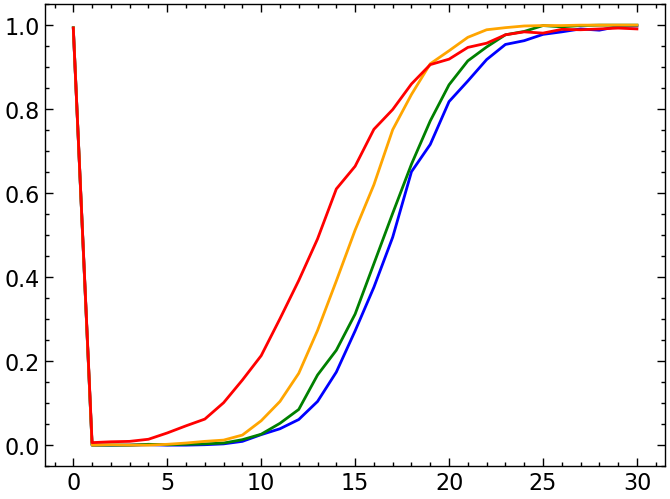

In [85]:
plt.plot(snr_range, accuracy_s0l_r1_C, color = "blue")
plt.plot(snr_range, accuracy_s0q_r1_C, color = "green")
plt.plot(snr_range, accuracy_s1_r1_C,  color = "orange")
plt.plot(snr_range, accuracy_s2_r1_C,  color = "red")

In [89]:
with open('store/files/multiclassifier/accuracy_vs_S_all_r1_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r1_C': accuracy_s0l_r1_C,
        'accuracy_s0q_r1_C': accuracy_s0q_r1_C,
        'accuracy_s1_r1_C' : accuracy_s1_r1_C,
        'accuracy_s2_r1_C' : accuracy_s2_r1_C,
    }, f)

### Accuracy: 2. run

In [103]:
loss_s0l_r2_C     = []
accuracy_s0l_r2_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[1] for i in range(1000)])

    loss, accuracy = model_all_r2_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r2_C.append(loss)
    accuracy_s0l_r2_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 1.0000 - loss: 4.1412e-05
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 52.9440
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 52.1723
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 51.2780
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 48.9565
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 47.5691
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 45.0635
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 5.6452e-04 - loss: 41.9921
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0029 - loss: 38.9469
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0047 - loss: 34.5686 
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0101 - loss: 30.6528
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0178 - loss: 24.8930
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step -

In [104]:
loss_s0q_r2_C     = []
accuracy_s0q_r2_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[2] for i in range(1000)])

    loss, accuracy = model_all_r2_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r2_C.append(loss)
    accuracy_s0q_r2_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.1949e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 58.7056 
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 58.4571
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 57.1209
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 56.0028
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 54.5889
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 51.3650
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 49.6219
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0047 - loss: 46.8830
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0034 - loss: 43.6474
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0145 - loss: 39.9480
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0362 - loss: 34.2833
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - a

In [105]:
loss_s1_r2_C     = []
accuracy_s1_r2_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[3] for i in range(1000)])

    loss, accuracy = model_all_r2_C.evaluate(res_example_normalized, y_example)

    loss_s1_r2_C.append(loss)
    accuracy_s1_r2_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9998 - loss: 4.9024e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 50.5310
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 50.9221
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 48.6993
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 48.6528
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 45.9765
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 44.0792
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 42.3994
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 4.2224e-04 - loss: 40.5441
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0082 - loss: 35.6776
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0153 - loss: 32.5963
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0210 - loss: 29.4584
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

In [106]:
loss_s2_r2_C     = []
accuracy_s2_r2_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[4] for i in range(1000)])

    loss, accuracy = model_all_r2_C.evaluate(res_example_normalized, y_example)

    loss_s2_r2_C.append(loss)
    accuracy_s2_r2_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0018
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 19.4219
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 19.4242
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 6.1713e-04 - loss: 18.8237
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0055 - loss: 17.9333
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0084 - loss: 17.5154
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0161 - loss: 15.3001
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0417 - loss: 14.5081
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0641 - loss: 13.0274
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1048 - loss: 11.2341
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1712 - loss: 9.2996
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2667 - loss: 7.5538
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3934 - l

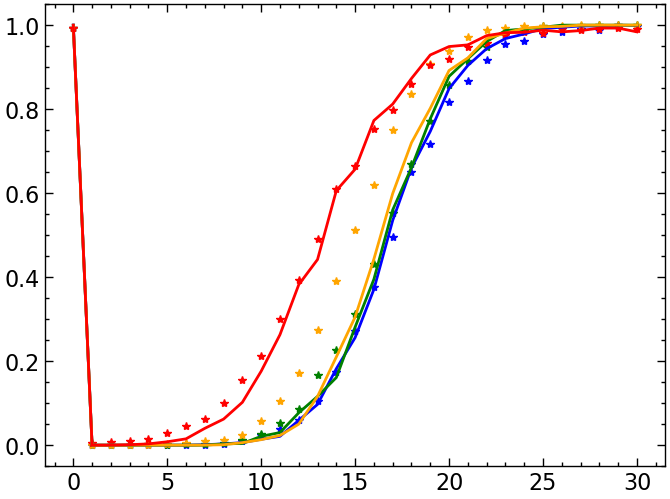

In [107]:
plt.plot(snr_range, accuracy_s0l_r1_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s0q_r1_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r1_C, "*",color = "orange")
plt.plot(snr_range, accuracy_s2_r1_C, "*", color = "red")

plt.plot(snr_range, accuracy_s0l_r2_C, color = "blue")
plt.plot(snr_range, accuracy_s0q_r2_C, color = "green")
plt.plot(snr_range, accuracy_s1_r2_C,  color = "orange")
plt.plot(snr_range, accuracy_s2_r2_C,  color = "red")

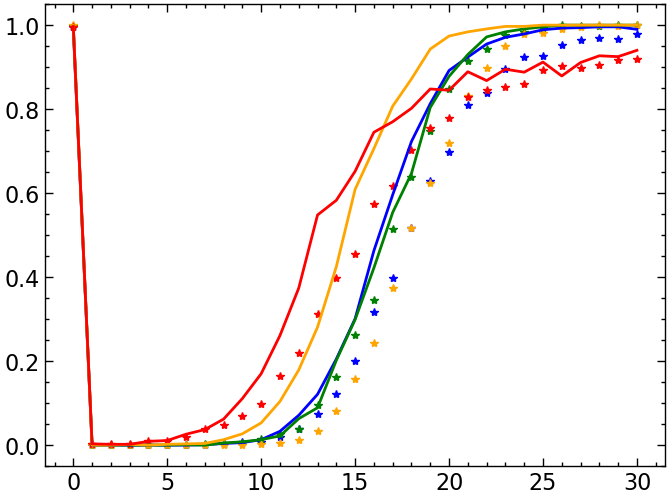

In [79]:
plt.plot(snr_range, accuracy_s0l_r1_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s0q_r1_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r1_C, "*",color = "orange")
plt.plot(snr_range, accuracy_s2_r1_C, "*", color = "red")

plt.plot(snr_range, accuracy_s0l_r2_C, color = "blue")
plt.plot(snr_range, accuracy_s0q_r2_C, color = "green")
plt.plot(snr_range, accuracy_s1_r2_C,  color = "orange")
plt.plot(snr_range, accuracy_s2_r2_C,  color = "red")

In [108]:
with open('store/files/multiclassifier/accuracy_vs_S_all_r2_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r2_C': accuracy_s0l_r2_C,
        'accuracy_s0q_r2_C': accuracy_s0q_r2_C,
        'accuracy_s1_r2_C' : accuracy_s1_r2_C,
        'accuracy_s2_r2_C' : accuracy_s2_r2_C,
    }, f)

### Accuracy: 3. run

In [109]:
loss_s0l_r3_C     = []
accuracy_s0l_r3_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[1] for i in range(1000)])

    loss, accuracy = model_all_r3_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r3_C.append(loss)
    accuracy_s0l_r3_C.append(accuracy)


0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9992 - loss: 0.0078
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 55.4621
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 53.1876
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 52.0418
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 7.9515e-04 - loss: 48.1904
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 44.5463
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0024 - loss: 40.5998
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0036 - loss: 37.5630
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0098 - loss: 30.3870
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0330 - loss: 26.0806
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0570 - loss: 21.0455
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1014 - loss: 14.5518
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 

In [110]:
loss_s0q_r3_C     = []
accuracy_s0q_r3_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[2] for i in range(1000)])

    loss, accuracy = model_all_r3_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r3_C.append(loss)
    accuracy_s0q_r3_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.0105e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 48.5167
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 48.2402
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 47.9769
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 46.7942
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 46.5982
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 2.2427e-04 - loss: 44.6976
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.5537e-04 - loss: 42.8989
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0075 - loss: 40.7188
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0062 - loss: 38.3801
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0218 - loss: 35.4366
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0348 - loss: 31.0340
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

In [111]:
loss_s1_r3_C     = []
accuracy_s1_r3_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[3] for i in range(1000)])

    loss, accuracy = model_all_r3_C.evaluate(res_example_normalized, y_example)

    loss_s1_r3_C.append(loss)
    accuracy_s1_r3_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 9.1985e-04
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 34.7158
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 32.8297
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 34.5708
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 32.3714
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0012 - loss: 31.3659
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0045 - loss: 29.2161
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0095 - loss: 27.0435
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0078 - loss: 25.0111
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0353 - loss: 21.4562
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0748 - loss: 18.1159
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1302 - loss: 15.0349
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 

In [112]:
loss_s2_r3_C     = []
accuracy_s2_r3_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[4] for i in range(1000)])

    loss, accuracy = model_all_r3_C.evaluate(res_example_normalized, y_example)

    loss_s2_r3_C.append(loss)
    accuracy_s2_r3_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9989 - loss: 0.0033
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0000e+00 - loss: 18.8894
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 18.2975
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 18.2529
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0032 - loss: 16.9757
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0060 - loss: 17.0564
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0164 - loss: 15.6480
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0204 - loss: 14.2184
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0708 - loss: 12.3505
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1126 - loss: 10.5862
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1995 - loss: 8.5722
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2742 - loss: 7.4238
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4280 - l

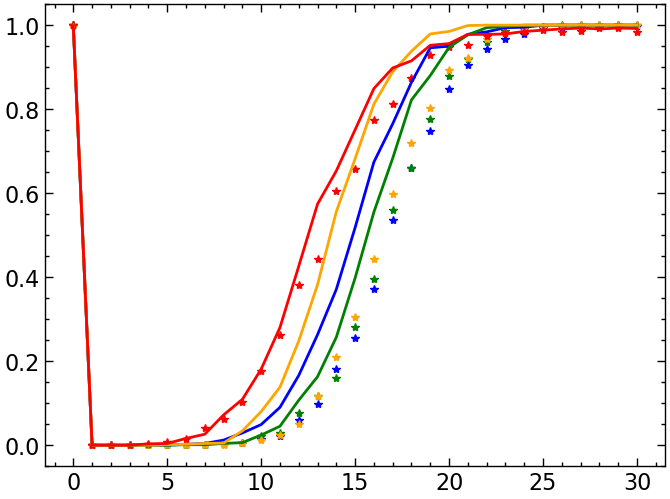

In [113]:
plt.plot(snr_range, accuracy_s0l_r2_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s0q_r2_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r2_C, "*",color = "orange")
plt.plot(snr_range, accuracy_s2_r2_C, "*", color = "red")

plt.plot(snr_range, accuracy_s0l_r3_C, color = "blue")
plt.plot(snr_range, accuracy_s0q_r3_C, color = "green")
plt.plot(snr_range, accuracy_s1_r3_C,  color = "orange")
plt.plot(snr_range, accuracy_s2_r3_C,  color = "red")

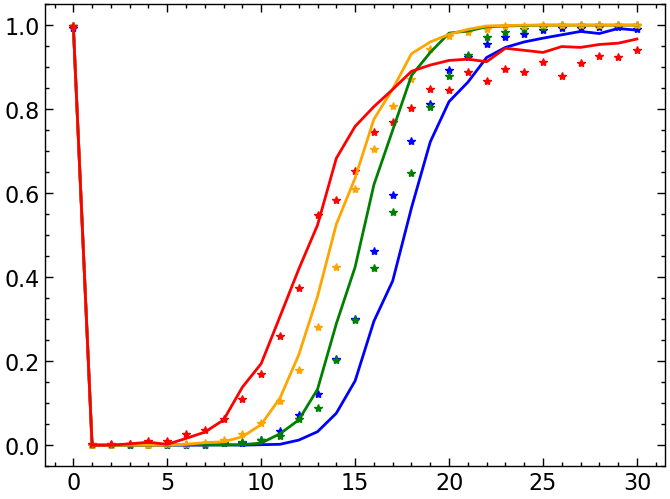

In [119]:
plt.plot(snr_range, accuracy_s0l_r2_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s0q_r2_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r2_C, "*",color = "orange")
plt.plot(snr_range, accuracy_s2_r2_C, "*", color = "red")

plt.plot(snr_range, accuracy_s0l_r3_C, color = "blue")
plt.plot(snr_range, accuracy_s0q_r3_C, color = "green")
plt.plot(snr_range, accuracy_s1_r3_C,  color = "orange")
plt.plot(snr_range, accuracy_s2_r3_C,  color = "red")

In [114]:
with open('store/files/multiclassifier/accuracy_vs_S_all_r3_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r3_C': accuracy_s0l_r3_C,
        'accuracy_s0q_r3_C': accuracy_s0q_r3_C,
        'accuracy_s1_r3_C' : accuracy_s1_r3_C,
        'accuracy_s2_r3_C' : accuracy_s2_r3_C,
    }, f)

### Accuracy: 4. run

In [115]:
loss_s0l_r4_C     = []
accuracy_s0l_r4_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[1] for i in range(1000)])

    loss, accuracy = model_all_r4_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r4_C.append(loss)
    accuracy_s0l_r4_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9998 - loss: 0.0010    
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 74.7756
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 75.5461
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 72.8820
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 69.5422
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 65.0263
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 61.6016
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 6.1713e-04 - loss: 54.0248
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 46.5264
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0066 - loss: 38.7633
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0230 - loss: 29.6981
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0593 - loss: 21.7174
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/ste

In [116]:
loss_s0q_r4_C     = []
accuracy_s0q_r4_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[2] for i in range(1000)])

    loss, accuracy = model_all_r4_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r4_C.append(loss)
    accuracy_s0q_r4_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.0224e-06
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 62.2920
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 60.1357
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 60.0366
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 58.9213
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 58.2555
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 55.4848
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0021 - loss: 53.8855
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0038 - loss: 51.2894
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0219 - loss: 47.6693
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0194 - loss: 43.6761
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0740 - loss: 37.3671
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - ac

In [117]:
loss_s1_r4_C     = []
accuracy_s1_r4_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[3] for i in range(1000)])

    loss, accuracy = model_all_r4_C.evaluate(res_example_normalized, y_example)

    loss_s1_r4_C.append(loss)
    accuracy_s1_r4_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 6.5886e-07
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 51.4040
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 50.8943
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 50.1592
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 49.6572
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 47.8239
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 46.6624
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 45.2011
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0021 - loss: 42.0732
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0036 - loss: 39.3589
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0045 - loss: 36.3720
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0341 - loss: 30.6264
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

In [118]:
loss_s2_r4_C     = []
accuracy_s2_r4_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[4] for i in range(1000)])

    loss, accuracy = model_all_r4_C.evaluate(res_example_normalized, y_example)

    loss_s2_r4_C.append(loss)
    accuracy_s2_r4_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 7.0582e-06
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 34.7482
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0033 - loss: 34.7090
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 34.1790
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 9.3564e-04 - loss: 32.8746
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0044 - loss: 30.3785
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0122 - loss: 28.9595
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0358 - loss: 25.9399
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0913 - loss: 21.4626
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1242 - loss: 17.4923
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2609 - loss: 13.2098
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3711 - loss: 10.8473
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.50

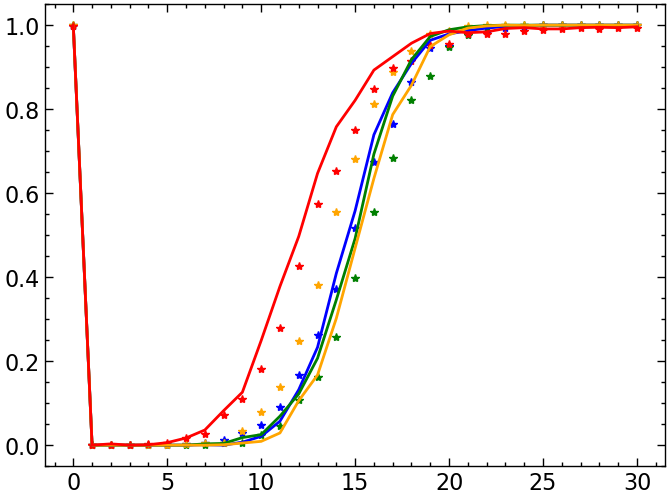

In [119]:
plt.plot(snr_range, accuracy_s0l_r3_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s0q_r3_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r3_C, "*",color = "orange")
plt.plot(snr_range, accuracy_s2_r3_C, "*", color = "red")

plt.plot(snr_range, accuracy_s0l_r4_C, color = "blue")
plt.plot(snr_range, accuracy_s0q_r4_C, color = "green")
plt.plot(snr_range, accuracy_s1_r4_C,  color = "orange")
plt.plot(snr_range, accuracy_s2_r4_C,  color = "red")

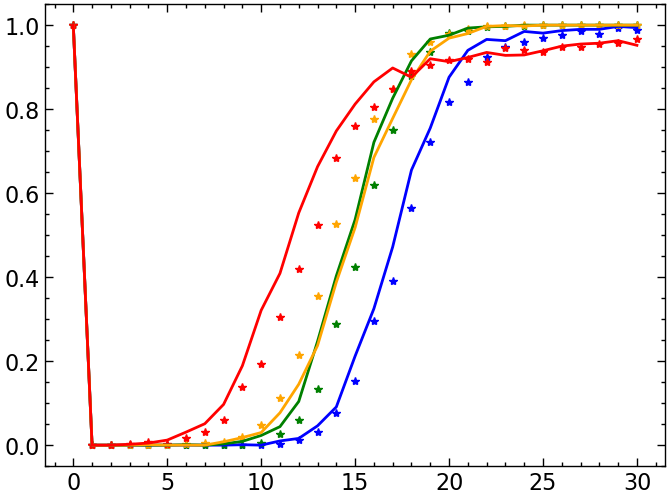

In [163]:
plt.plot(snr_range, accuracy_s0l_r3_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s0q_r3_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r3_C, "*",color = "orange")
plt.plot(snr_range, accuracy_s2_r3_C, "*", color = "red")

plt.plot(snr_range, accuracy_s0l_r4_C, color = "blue")
plt.plot(snr_range, accuracy_s0q_r4_C, color = "green")
plt.plot(snr_range, accuracy_s1_r4_C,  color = "orange")
plt.plot(snr_range, accuracy_s2_r4_C,  color = "red")

In [120]:
with open('store/files/multiclassifier/accuracy_vs_S_all_r4_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r4_C': accuracy_s0l_r4_C,
        'accuracy_s0q_r4_C': accuracy_s0q_r4_C,
        'accuracy_s1_r4_C' : accuracy_s1_r4_C,
        'accuracy_s2_r4_C' : accuracy_s2_r4_C,
    }, f)

### Accuracy: 5. run

In [121]:
loss_s0l_r5_C     = []
accuracy_s0l_r5_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[1] for i in range(1000)])

    loss, accuracy = model_all_r5_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r5_C.append(loss)
    accuracy_s0l_r5_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 6.2224e-05
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 76.3439
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 74.6370
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 73.5317 
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 66.3051
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 64.5720
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 3.7920e-04 - loss: 57.7576 
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 2.2427e-04 - loss: 49.9949
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0049 - loss: 40.4464
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0050 - loss: 33.7315
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0165 - loss: 23.4761
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0414 - loss: 16.5279
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

In [122]:
loss_s0q_r5_C     = []
accuracy_s0q_r5_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[2] for i in range(1000)])

    loss, accuracy = model_all_r5_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r5_C.append(loss)
    accuracy_s0q_r5_C.append(accuracy)


0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 4.0490e-06
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 65.9482
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 64.8753
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 63.5931 
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 62.7895
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 60.4913
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0014 - loss: 58.1864
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0049 - loss: 55.8776
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0012 - loss: 53.6702  
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0103 - loss: 49.9675
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0195 - loss: 44.2507
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0824 - loss: 38.1334
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accur

In [123]:
loss_s1_r5_C     = []
accuracy_s1_r5_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[3] for i in range(1000)])

    loss, accuracy = model_all_r5_C.evaluate(res_example_normalized, y_example)

    loss_s1_r5_C.append(loss)
    accuracy_s1_r5_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 8.5734e-06
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0000e+00 - loss: 44.6201
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 44.9025
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0000e+00 - loss: 43.9081
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0014 - loss: 42.4471
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 42.5027
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0000e+00 - loss: 40.0776
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 37.4631
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0160 - loss: 35.2269
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0179 - loss: 33.1212
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0464 - loss: 28.4733
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0969 - loss: 24.1872
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - ac

In [124]:
loss_s2_r5_C     = []
accuracy_s2_r5_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_all_C.transform(res_example)

    if j == 0:
        y_example = np.array([one_hot_encoded[0] for i in range(1000)])
    else:
        y_example = np.array([one_hot_encoded[4] for i in range(1000)])

    loss, accuracy = model_all_r5_C.evaluate(res_example_normalized, y_example)

    loss_s2_r5_C.append(loss)
    accuracy_s2_r5_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.8961e-05
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 5.1468e-04 - loss: 31.2647
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0022 - loss: 30.8515
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0000e+00 - loss: 30.3820
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0011 - loss: 27.5642
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0066 - loss: 26.8240
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0391 - loss: 24.0578
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0631 - loss: 22.0028
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1290 - loss: 17.9118
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2524 - loss: 13.4888
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3603 - loss: 10.1338
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5371 - loss: 6.7745
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6456 - 

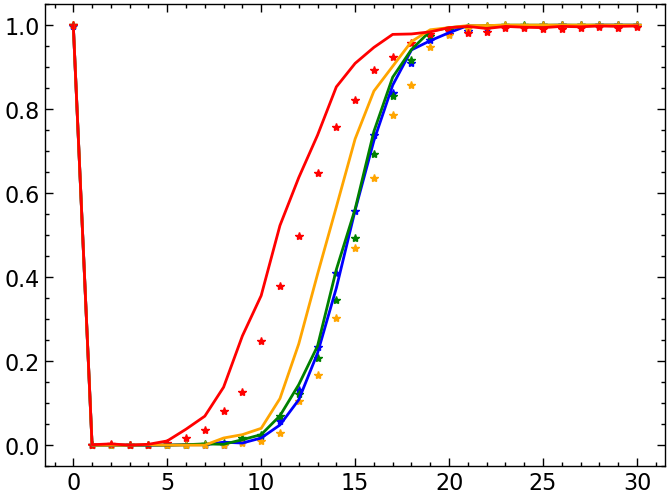

In [125]:
plt.plot(snr_range, accuracy_s0l_r4_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s0q_r4_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r4_C, "*",color = "orange")
plt.plot(snr_range, accuracy_s2_r4_C, "*", color = "red")

plt.plot(snr_range, accuracy_s0l_r5_C, color = "blue")
plt.plot(snr_range, accuracy_s0q_r5_C, color = "green")
plt.plot(snr_range, accuracy_s1_r5_C,  color = "orange")
plt.plot(snr_range, accuracy_s2_r5_C,  color = "red")

In [151]:
with open('store/files/multiclassifier/accuracy_vs_S_all_r5_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r5_C': accuracy_s0l_r5_C,
        'accuracy_s0q_r5_C': accuracy_s0q_r5_C,
        'accuracy_s1_r5_C' : accuracy_s1_r5_C,
        'accuracy_s2_r5_C' : accuracy_s2_r5_C,
    }, f)

In [153]:
import pickle

with open('store/files/multiclassifier/accuracy_vs_S_all_r1_C.pkl', 'rb') as f:
    data = pickle.load(f)
accuracy_s0l_r1_C = data['accuracy_s0l_r1_C']
accuracy_s0q_r1_C = data['accuracy_s0q_r1_C']
accuracy_s1_r1_C  = data['accuracy_s1_r1_C']
accuracy_s2_r1_C  = data['accuracy_s2_r1_C']


with open('store/files/multiclassifier/accuracy_vs_S_all_r4_C.pkl', 'rb') as f:
    data = pickle.load(f)
accuracy_s0l_r4_C = data['accuracy_s0l_r4_C']
accuracy_s0q_r4_C = data['accuracy_s0q_r4_C']
accuracy_s1_r4_C  = data['accuracy_s1_r4_C']
accuracy_s2_r4_C  = data['accuracy_s2_r4_C']

with open('store/files/multiclassifier/accuracy_vs_S_all_r5_C.pkl', 'rb') as f:
    data = pickle.load(f)
accuracy_s0l_r5_C = data['accuracy_s0l_r5_C']
accuracy_s0q_r5_C = data['accuracy_s0q_r5_C']
accuracy_s1_r5_C  = data['accuracy_s1_r5_C']
accuracy_s2_r5_C  = data['accuracy_s2_r5_C']

In [18]:
snr_range = range(0, 30 + 1, 1)

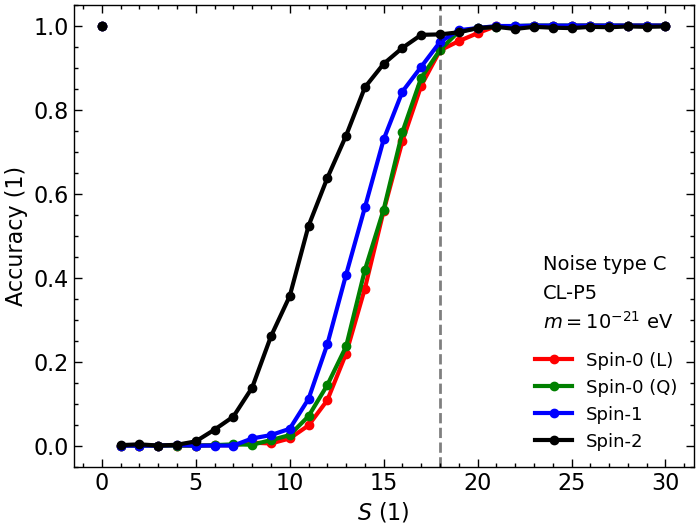

In [167]:
#plt.plot(0, accuracy_s0l_r1_C[0], "*", ms = 6, color = "red", alpha = 1)
#plt.plot(snr_range[1:], accuracy_s0l_r1_C[1:], "*", ms = 6, lw = 3, color = "red", label = "", alpha = 0.5)

#plt.plot(0, accuracy_s0q_r1_C[0], "*", ms = 6, color = "green", alpha = 1)
#plt.plot(snr_range[1:], accuracy_s0q_r1_C[1:], "*", ms = 6, lw = 3, color = "green", label = "", alpha = 0.5)

#plt.plot(0, accuracy_s1_r1_C[0], "*", ms = 6, color = "blue", alpha = 1)
#plt.plot(snr_range[1:], accuracy_s1_r1_C[1:], "*", ms = 6, lw = 3, color = "blue", label = "", alpha = 0.5)

#plt.plot(0, accuracy_s2_r1_C[0], "*", ms = 6, color = "black", alpha = 1)
#plt.plot(snr_range[1:], accuracy_s2_r1_C[1:], "*", ms = 6, lw = 3, color = "black", label = "", alpha = 0.5)

###

plt.plot(0, accuracy_s0l_r5_C[0], "o", ms = 6, color = "red", alpha = 1)
plt.plot(snr_range[1:], accuracy_s0l_r5_C[1:], "-o", ms = 6, lw = 3, color = "red", label = "Spin-0 (L)", alpha = 1)

plt.plot(0, accuracy_s0q_r5_C[0], "o", ms = 6, color = "green", alpha = 1)
plt.plot(snr_range[1:], accuracy_s0q_r5_C[1:], "-o", ms = 6, lw = 3, color = "green", label = "Spin-0 (Q)", alpha = 1)

plt.plot(0, accuracy_s1_r5_C[0], "o", ms = 6, color = "blue", alpha = 1)
plt.plot(snr_range[1:], accuracy_s1_r5_C[1:], "-o", ms = 6, lw = 3, color = "blue", label = "Spin-1", alpha = 1)

plt.plot(0, accuracy_s2_r5_C[0], "o", ms = 6, color = "black", alpha = 1)
plt.plot(snr_range[1:], accuracy_s2_r5_C[1:], "-o", ms = 6, lw = 3, color = "black", label = "Spin-2", alpha = 1)

plt.axvline(x=18, color='black', linestyle='--', linewidth=2, alpha = 0.5)

plt.xlabel(r"$S$ (1)") 
plt.ylabel("Accuracy (1)") 

plt.text(23.5, 0.42, 'Noise type C', fontsize=14, color="black")
plt.text(23.5, 0.35, 'CL-P5', fontsize=14, color="black")
plt.text(23.5, 0.28, r'$m=10^{-21}$ eV', fontsize=14, color="black")

plt.legend(ncol = 1, loc = "lower right", fontsize = 13)

plt.savefig("store/plots/multiclassifier/1_accuracy_vs_S_C_multiclassifier_round5.png", dpi=300, bbox_inches='tight')

plt.show()